In [56]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import pickle

from numpy import loadtxt, savetxt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_label = pd.read_csv('data/test_labels.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [3]:
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [4]:
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [5]:
lens = train_data.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

Text(0, 0.5, 'number of comments')

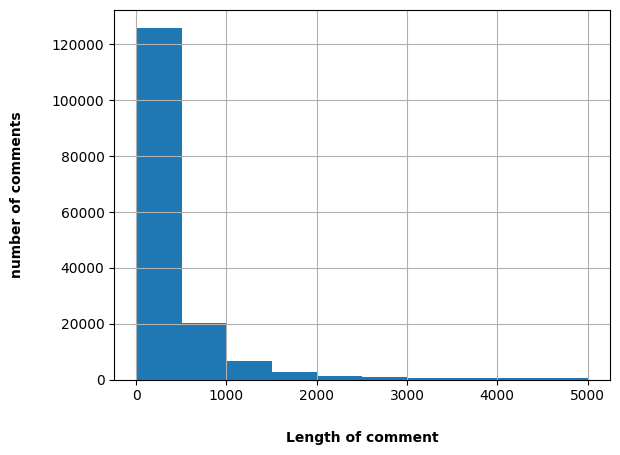

In [6]:
histogram = lens.hist();
histogram.set_xlabel("Length of comment", labelpad=20, weight='bold', size=10)
histogram.set_ylabel("number of comments", labelpad=20, weight='bold', size=10)

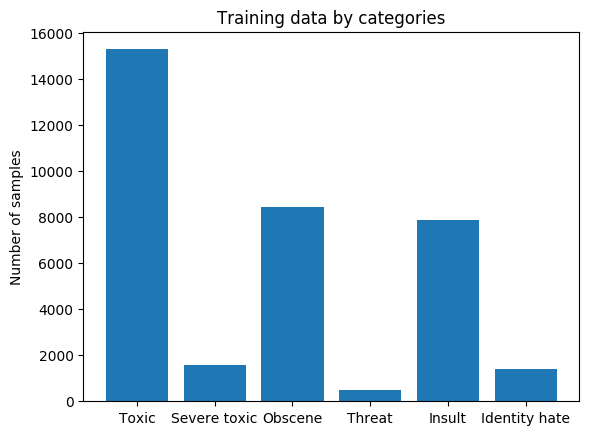

In [7]:
objects = ('Toxic', 'Severe toxic', 'Obscene', 'Threat', 'Insult', 'Identity hate')
y_pos = np.arange(len(objects))
performance = [15294, 1595, 8449, 478, 7877, 1405]

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of samples')
plt.title('Training data by categories')

plt.show()

In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data['none'] = 1 - train_data[label_cols].max(axis=1)
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
len(train_data), len(test_data)

(159571, 153164)

In [10]:
train = train_data.copy()
test = test_data.copy()

In [11]:
COMMENT = 'comment_text'

In [12]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [13]:
import datetime
start = datetime.datetime()
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])
print(datatime.datetime() - start)

In [14]:
x = trn_term_doc
test_x = test_term_doc

In [54]:
def predict_from_text(text):
    preds = np.zeros((len(label_cols)))
    spare_matrix = vec.transform([text])
    for i in range(len(label_cols)):    
        preds[i] = m[i].predict_proba(spare_matrix.multiply(r[i]))[:,1]
    return preds

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y, m):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r
        
    return m, r, preds

def preds_to_json(preds):
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    res = {}
    for i, j in enumerate(label_cols):
        res[j] = preds[i]
    return res

def save_models(path, m):
    for i, filename in enumerate(label_cols):
        pickle_out = open(path + f"/{filename}.pickle", "wb")
        pickle.dump(m[i], pickle_out)
        pickle_out.close()

def load_models(path):
    models = [None for _ in range(len(label_cols))]
    for i, filename in enumerate(label_cols):
        pickle_in = open(path + f"/{filename}.pickle","rb")
        models[i] = pickle.load(pickle_in)
        pickle_in.close()
    return models

def predict_from_text(text, m):
    preds = np.zeros((len(label_cols)))
    spare_matrix = vec.transform([text])
    for i in range(len(label_cols)):    
        preds[i] = m[i].predict_proba(spare_matrix.multiply(r[i]))[:,1]
    return preds

def save_r(path, r):
    for i, filename in enumerate(label_cols):
        savetxt(path + f"/{filename}.csv", r[i])

def load_r(path):
    r = [None for _ in range(len(label_cols))]
    for i, filename in enumerate(label_cols):
        r[i] = loadtxt(path + f"/{filename}.csv", r[i])
    return r

def extract_res(prediction_results):
    return prediction_results.loc[prediction_results['id'].isin(test_id)]



def plot_roc_curve(evaluation_data, prediction_results):
    for i, col in enumerate(evaluation_data.columns):
        eval_col = evaluation_data[col].values.tolist()
        pred_col = prediction_results[col].values.tolist()        
        plt.subplot(3, 2, i + 1)
        label = f"{col} - ROC curve"
        lr_fpr, lr_tpr, _ = roc_curve(eval_col, pred_col)
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label=label)
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.legend()

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    
def evaluate(evaluation_data, prediction_results, roc_curve=False):
    """ 
    Mean ROC over all columns
    """
    evaluation_data = evaluation_data.drop('id', 1)
    evaluation_data.head()
    prediction_results = prediction_results.drop('id', 1)
    n = 0
    score = 0
    for (name, prediction) in prediction_results.iteritems():    
        evaluation = evaluation_data[name].values.tolist()
        ra_score = roc_auc_score(evaluation, prediction)
        score += ra_score
        print('{:<20}  {:>20}'.format(name.upper(), ra_score))
        n += 1
        
    if roc_curve:
        plot_roc_curve(evaluation_data, prediction_results)
    
    score /= n
    print('ROC score: %.5f'%(score))
    
    
def train_regression():
    m = [None for _ in range(len(label_cols))]
    r = [None for _ in range(len(label_cols))]
    for i, j in enumerate(label_cols):
        print('fit', j)
        base = LogisticRegression(C=4, dual=False)
        m[i], r[i] = get_mdl(train[j], base)
        preds[:,i] = m[i].predict_proba(test_x.multiply(r[i]))[:,1]
        
def train_model(model):
    m = [None for _ in range(len(label_cols))]
    r = [None for _ in range(len(label_cols))]
    for i, j in enumerate(label_cols):
        base = clone(model)
        print('fit', j)
#         base = LogisticRegression(C=4, dual=False)
        m[i], r[i] = get_mdl(train[j], base)
        preds[:,i] = m[i].predict_proba(test_x.multiply(r[i]))[:,1]
        
    return m, r, preds
test_id = test_label.loc[test_label['toxic'] != -1]['id']
preds = np.zeros((len(test), len(label_cols)))

def evaluate_from_preds():
    evaluation_data = test_label[test_label.toxic != -1]
    submid = pd.DataFrame({'id': subm["id"]})
    submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
    prediction_results = extract_res(submission)
    evaluate(evaluation_data, prediction_results, roc_curve=True)

In [26]:
# load models
r = load_r("saved_models")
m = load_models("saved_models")
for i, j in enumerate(label_cols):
    preds[:,i] = m[i].predict_proba(test_x.multiply(r[i]))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
TOXIC                   0.9646824801144795
SEVERE_TOXIC            0.9809197267948062
OBSCENE                 0.9715454366597754
THREAT                  0.9860822171238491
INSULT                  0.9692584623985867
IDENTITY_HATE           0.9699324738921132
ROC score: 0.97374


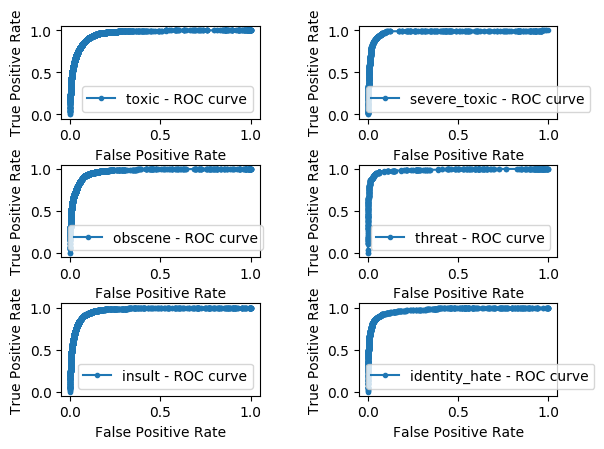

In [68]:
model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001)
model = CalibratedClassifierCV(model, cv=5, method='sigmoid')
m, r, preds = train_model(model)
evaluate_from_preds()

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
TOXIC                   0.9651612399596617
SEVERE_TOXIC            0.9844885918271038
OBSCENE                 0.9773866194277416
THREAT                  0.9919648227622527
INSULT                  0.9726018856587586
IDENTITY_HATE           0.9796609495595021
ROC score: 0.97854


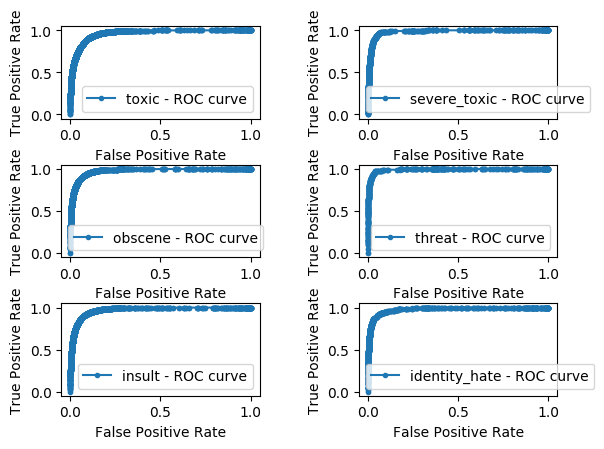

In [62]:
model = LogisticRegression(C=0.7, dual=False, solver='liblinear')
m, r, preds = train_model(model)
evaluate_from_preds()

In [18]:
# 0.97754, 0.97846, 0.97848, 0.97852: model = LogisticRegression(C=0.7, dual=False, solver='liblinear')
# from sklearn.svm import SVC
# model = SVC(probability=True, verbose=True)
# m, r, preds = train_model(model)
# evaluate_from_preds()

In [67]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128, 32), \
                      random_state=1, verbose=True)
m, r, preds = train_model(model)
evaluate_from_preds()

fit toxic


KeyboardInterrupt: 

In [63]:
score = (0.9651612399596617 + 0.9844885918271038 + 0.9756670338872196 + 0.9919648227622527 + 0.9702455459162238 + 0.980636842942781) / 6

In [31]:
score

0.9773021925085471